<a href="https://colab.research.google.com/github/R-802/LING-226-Assignments/blob/main/Assignment_One.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LING226 2023 T3 Assignment One
- Shemaiah Rangitaawa `300601546`
- Attempting Challenge

> **Note:** Given the computationally demanding tasks in some parts of this notebook, operating in a GPU-based runtime environment is beneficial. However, it's not necessary to run the cells at all, as I have tried to include as much detail as possible in my discussions, explanations, and comments. This notebook also uses certain features exclusive to Google Colab, in particular its form functionality. However, this too is not required.


In [1]:
import string
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt', quiet=True)

def clean_text(text, stop_words=None, remove_punctuation=True, to_lowercase=True, keep_delimiters=False):
    # Convert text to lowercase to normalize the data
    if to_lowercase:
        text = text.lower()

    # Remove punctuation from the text
    if remove_punctuation:
        if keep_delimiters:
            # Keep sentence delimiters: ., !, and ?
            punctuation_to_remove = string.punctuation.replace('.', '').replace('!', '').replace('?', '')
        else:
            punctuation_to_remove = string.punctuation

        text = text.translate(str.maketrans('', '', punctuation_to_remove))

    words = word_tokenize(text)

    # Remove stop words from the tokenized list if a stop word list is provided
    if stop_words:
        filtered_words = [word for word in words if word not in stop_words]
    else:
        filtered_words = words

    # Combine the filtered tokens back into a single string
    return ' '.join(filtered_words)

## **Text Preprocessing**

In [2]:
def preprocess_tf(text, stop_words, min_freq=1, max_freq=float('inf')):
    # Clean the text using the previously defined function, removing stop words
    text = clean_text(text, stop_words)

    words = word_tokenize(text)

    # Create a frequency distribution of the words
    frequency = Counter(words)

    # Filter out words based on their frequency, keeping those within the specified range
    filtered_words = [word for word in words if min_freq <= frequency[word] <= max_freq]

    # Rejoin the filtered words into a single string
    return ' '.join(filtered_words)

## **Text Metrics**

In [43]:
import nltk
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from collections import Counter

def lexical_diversity(words):
    # Calculate lexical diversity as the ratio of unique words to total words
    return len(set(words)) / len(words) if words else 0

def text_metrics(text, exclude_delimiters=False):
    words = word_tokenize(text)
    overall_lexical_diversity = lexical_diversity(words)
    num_words = len(words)

    sentences = sent_tokenize(text)
    sentence_diversities = [lexical_diversity(word_tokenize(sentence)) for sentence in sentences if sentence.strip()]
    avg_sentence_lexical_diversity = sum(sentence_diversities) / len(sentence_diversities) if sentence_diversities else 0

    # Filtering out sentence delimiters if the option is set
    if exclude_delimiters:
        words_filtered = [word for word in words if word not in ['.', '!', '?']]
    else:
        words_filtered = words

    top_ten_words = Counter(words_filtered).most_common(10)
    num_sentences = len(sentence_diversities)
    freq_distribution = Counter(words_filtered)

    return {
        'num_words': num_words,
        'lexical_diversity': overall_lexical_diversity,
        'avg_sentence_lexical_diversity': avg_sentence_lexical_diversity,
        'top_ten_words': top_ten_words,
        'num_sentences': num_sentences,
        'frequency_distribution': freq_distribution
    }

###**Formatting Function for Text Metrics**

In [4]:
def format_metrics(titles, metrics_list, is_preprocessed=True):
    for title, metrics in zip(titles, metrics_list):
        # Format the top ten words and their frequencies for display
        if metrics['top_ten_words']:
            formatted_top_words = ', '.join([f"'{word}' ({freq})" for word, freq in metrics['top_ten_words']])
            # Extracting the highest frequency word and its frequency
            highest_word, highest_freq = metrics['top_ten_words'][0]
        else:
            formatted_top_words = "None"
            highest_word, highest_freq = ("N/A", 0)

        # Convert the lexical diversities to percentages for easier interpretation
        overall_diversity_percentage = metrics['lexical_diversity'] * 100
        avg_sentence_diversity_percentage = metrics['avg_sentence_lexical_diversity'] * 100

        # Print the formatted metrics for each text
        print(f"--------- Text Metrics for {title} ---------")
        print(f"Total Words: {metrics['num_words']}")
        # Include sentence-related metrics only for non-preprocessed texts
        if not is_preprocessed:
            print(f"Total Sentences: {metrics['num_sentences']}")
            print(f"Average Lexical Diversity of Sentences: {avg_sentence_diversity_percentage:.2f}%")
        print(f"Overall Lexical Diversity: {overall_diversity_percentage:.2f}%")
        print(f"Top Ten Most Frequent Words: {formatted_top_words}")
        print(f"Highest Frequency Word: '{highest_word}' (Frequency: {highest_freq})")
        print()

# **Experimentation And Disscussion**

**Notes:** I have chosen to use the NLTK's stopword list for preprocessing.

In [5]:
# @title ##**Importing and Reading `TP001.txt`, `TP002.txt` from URL and `austen-emma.txt` from NLTK corpora** {display-mode: "form"}
# @markdown It's only required to run this cell once. This cell is dedicated to importing `TP001.txt`, `TP002.txt`, and `austen-emma.txt` for processing. Spellcheck is performed on `TP001.txt`, `TP002.txt` to ensure consistency.
!wget 'https://raw.githubusercontent.com/scskalicky/LING-226-vuw/main/the-current/tp001.txt'
!wget 'https://raw.githubusercontent.com/scskalicky/LING-226-vuw/main/the-current/tp002.txt'
!pip install symspellpy

import pkg_resources
from nltk.corpus import gutenberg
from symspellpy import SymSpell, Verbosity

nltk.download('gutenberg', quiet=True)

def read_comments_from_file(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        return " ".join(line.split('\t')[1].strip() for line in file if '\t' in line)

def spellcheck(text):
    # Initialize SymSpell
    symspell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
    symspell.load_dictionary(dictionary_path, term_index=0, count_index=1)

    # Tokenize the input text
    words = text.split()
    corrected_text = []
    for word in words:
        # Get the best suggestion
        suggestions = symspell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)

        # Use the most likely suggestion, or the original word if no suggestion found
        if suggestions:
            corrected_word = suggestions[0].term
        else:
            corrected_word = word
        corrected_text.append(corrected_word)

    # Join the corrected words back into a string
    return ' '.join(corrected_text)

# Read and process the texts
tp001 = read_comments_from_file('tp001.txt')
tp002 = read_comments_from_file('tp002.txt')

# Using Emma by Jane Austen 1816
emma_text = gutenberg.raw('austen-emma.txt')

# Fix spelling
tp001_text = spellcheck(tp001)
tp002_text = spellcheck(tp002)

## **Initializing NLTK Stopwords**
I have also added some random words and characters that appeared during analysis and contributed little to the overall contents of the texts.

In [35]:
import nltk
from nltk.corpus import stopwords

# Using stopwords from NLTK
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Additional words to the stopwords set
additional_stopwords = {'ä', 'å', 'pä', 'n', 's', 'r', 'tä', 'wä',
                        'thä', 'bä', 'ahhhhhhhhhhhh', 'hxbdjs',
                        'aga', 've', 'fhdvb', 'vvvvv', '--'}
stop_words.update(additional_stopwords)

In [7]:
# @title ##**Graphing Function Definition** {display-mode: "form"}
# @markdown Although `text_metrics` already returns a list of the top 10 words, for flexiblity, I instead decided to use the frequency distribution returned from `text_metrics` and extract the `n` most common words.

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from nltk.probability import FreqDist

def plot_word_frequency(metrics_list, n, titles, canvas_title):
    num_plots = len(metrics_list)
    fig = make_subplots(rows=num_plots, cols=1, subplot_titles=titles)
    for i, metrics in enumerate(metrics_list, start=1):
        # Extract frequency distribution and get the top n words
        freq_dist = metrics['frequency_distribution']
        word_freq = freq_dist.most_common(n)

        # Separate the words and their frequencies
        words = [wf[0] for wf in word_freq]
        frequencies = [wf[1] for wf in word_freq]

        # Create a colorscale with the same number of colors as the number of words
        colorscale = px.colors.sequential.Emrld_r[:len(words)]

        # Add the plot to the subplot
        fig.add_trace(
            go.Bar(
                x=frequencies,
                y=words,
                orientation='h',
                name=titles[i-1],
                marker=dict(
                    color=frequencies,
                    colorscale=colorscale
                )
            ),
            row=i, col=1
        )

    fig.update_layout(
        title=canvas_title,
        height=300 * num_plots,  # Adjust height based on number of plots
        showlegend=False
    )

    # Reverse the y-axis to show the highest frequency on top for each subplot
    for i in range(num_plots):
        fig.update_yaxes(autorange="reversed", row=i + 1, col=1)

    # Show the plot
    fig.show()

## **Analysis and Overview of Key Metrics from Sample Texts Before and After Pre-processing**




###**Analysis of Raw Unprocessed Texts**
**Emma by Jane Austen**

The metrics confirm the characteristics of a classic novel: extensive length, a high number of sentences, and a low overall lexical diversity, which is typical for long narratives. The high average lexical diversity per sentence reflects Jane Austen's varied and rich use of language within individual sentences.

**TP001 (Petrol cars should be banned by 2030)**

The shorter length and significantly higher overall lexical diversity compared to "Emma" suggest diverse viewpoints and varied vocabulary used by different respondents. The lower average lexical diversity per sentence could be due to more straightforward, argumentative sentence structures typical in responses or opinions. The frequent use of words like 'we', 'be', and 'for' indicates the text's focus on collective action and future-oriented propositions.

**TP002 (Supermarkets should only sell sustainably caught fish)**

This text is longer than TP001, possibly indicating more detailed responses or larger numbers of contributors. The presence of 'fish' among the most frequent words directly reflects the text's topic. The overall and average lexical diversities suggest a balance between varied vocabulary and straightforward sentence structures, possibly due to the mix of technical terms and general argumentative language in the responses.

Overall, the raw text metrics show that the three texts have different characteristics. Emma has the highest number of words and sentences, while TP001 has the lowest. TP001 also has the highest lexical diversity, while Emma has the lowest. The most frequent word in all three texts is 'the', which is expected in raw texts.

**Top 10 Words from Raw Texts**

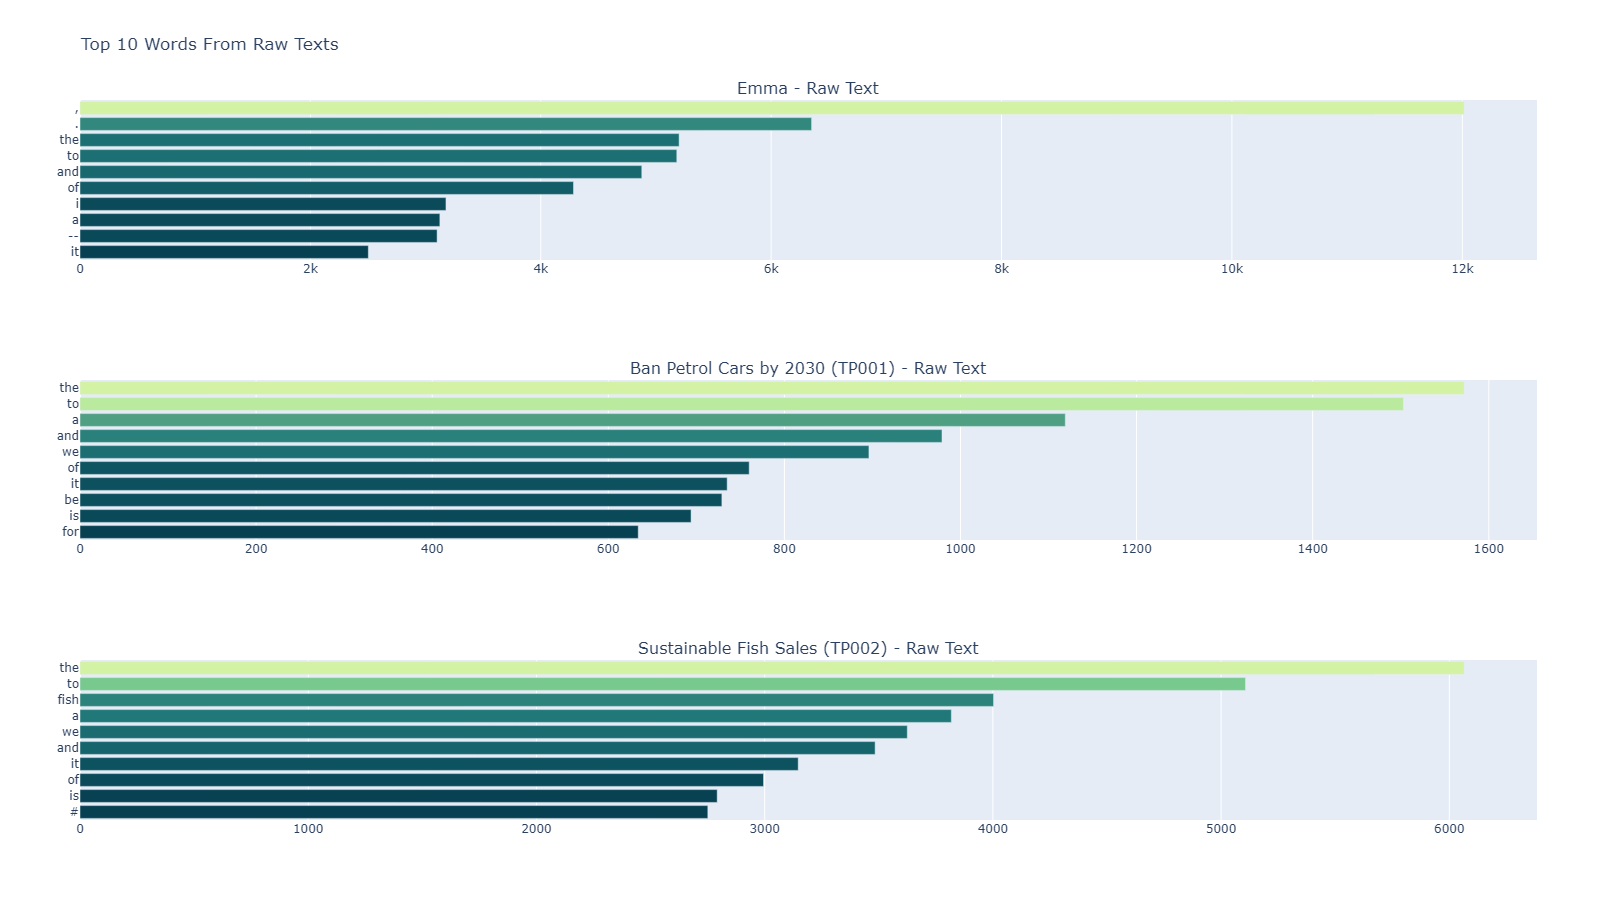

For Emma, the graph shows a high frequency of the most common English words like 'the', 'to', 'and', 'of', and 'a'. This is typical for unprocessed English-language texts, as these words are often the glue that holds sentences together. The substantial frequency of these words suggests a rich narrative style, which is expected in a classic novel that utilizes complex sentence structures and descriptive passages.

In TP001, the frequencies of the top words are noticeably lower than in Emma, yet 'the' remains the most common. However, the presence of words like 'we', 'be', 'is', and 'for' indicate a more conversational or argumentative text, reflecting the discourse on a topic where personal opinions, suggestions, and reasoning are prominent.

"TP002" shows a unique inclusion of the word 'fish', which stands out against the backdrop of otherwise common English words. The word 'fish' having a high frequency immediately reveals the texts subject matter, which is the sustainablity of fish sales.

The graph also illustrates the difference in vocabulary richness and text length among the three texts. Emma appears to have a much higher word count, reflective of its status as a novel, whereas "TP001" and "TP002" have fewer words.

Overall, the unprocessed word frequencies provide a baseline understanding of each text's content and style. The frequent appearance of common words is expected, but the presence of specific terms like 'fish' in "TP002" offers a hint of the text's thematic focus. This data plays an important role in subsequent phases of text analysis and proved particularly valuable in the following section, which involved experimentation with and determination of word frequency thresholds for removal.

In [8]:
# @title Raw Text Metrics {display-mode: "form"}
# @markdown

# Get text metrics for raw unprocessed text
emma_metrics = text_metrics(emma_text)
tp001_metrics = text_metrics(tp001_text)
tp002_metrics = text_metrics(tp002_text)

# Prepare titles and metrics for the formatting
titles = ["Emma - Raw Text", "Ban Petrol Cars by 2030 (TP001) - Raw Text", "Sustainable Fish Sales (TP002) - Raw Text"]
metrics_list = [emma_metrics, tp001_metrics, tp002_metrics]
format_metrics(titles, metrics_list, is_preprocessed=False)

--------- Text Metrics for Emma - Raw Text ---------
Total Words: 191781
Total Sentences: 7493
Average Lexical Diversity of Sentences: 90.32%
Overall Lexical Diversity: 4.14%
Top Ten Most Frequent Words: ',' (12016), '.' (6351), 'the' (5201), 'to' (5181), 'and' (4877), 'of' (4284), 'i' (3177), 'a' (3124), '--' (3100), 'it' (2503)
Highest Frequency Word: ',' (Frequency: 12016)

--------- Text Metrics for Ban Petrol Cars by 2030 (TP001) - Raw Text ---------
Total Words: 39665
Total Sentences: 101
Average Lexical Diversity of Sentences: 55.22%
Overall Lexical Diversity: 9.48%
Top Ten Most Frequent Words: 'the' (1572), 'to' (1503), 'a' (1119), 'and' (979), 'we' (896), 'of' (760), 'it' (735), 'be' (729), 'is' (694), 'for' (634)
Highest Frequency Word: 'the' (Frequency: 1572)

--------- Text Metrics for Sustainable Fish Sales (TP002) - Raw Text ---------
Total Words: 149382
Total Sentences: 533
Average Lexical Diversity of Sentences: 62.66%
Overall Lexical Diversity: 5.53%
Top Ten Most Frequ

In [9]:
# Plot the top 10 words from each text
plot_word_frequency(metrics_list, 10, titles, "Top 10 Words From Raw Texts")

---

###**Analysis of Results of Preprocessing the Texts**
**Emma**

The preprocessing of Jane Austen's "Emma" often led to a noticeable decrease in both the total word count and the overall lexical diversity. This reduction in lexical diversity indicates that the text is now predominantly composed of a limited range of words. A striking feature of this condensed version is the repeated appearance of character names such as 'Emma' and 'Harriet.' Their prominence reveals that the narrative is centered around these key figures.

Additionally, the frequent usage of words like 'could', 'would', and 'must' mirrors the speculative and reflective tone of the novel. These words suggest a focus on the characters' internal deliberations and the hypothetical scenarios they consider, especially in their social interactions and personal musings. However, this narrowed lexical range also implies that the preprocessing may have inadvertently stripped away much of Austen's linguistic richness. As a result, some of the subtleties and less common words that add depth and nuance to her writing might have been lost. This loss potentially affects the intricate layers and the full essence of the original text, which is characterized by its rich and varied vocabulary.

**TP001**

The preprocessed version of TP001, focusing on the topic of banning petrol cars by 2030, shows a notably slightly higher lexical diversity (2.46%) compared to "Emma". This higher diversity could be attributed to the inclusion of more specialized vocabulary pertinent to environmental issues and automobile technology. The text is dominated by words like 'cars', 'petrol', 'environment', and 'electric', clearly reflecting its environmental theme. The presence of words such as 'need', 'think', 'change', 'better', and 'good' points towards a text that is not just descriptive but also persuasive, likely advocating for environmental action or policy change. These words suggest an opinionated nature of the text, possibly comprising arguments, suggestions, or reflections on the environmental impact of petrol cars and the potential benefits of electric vehicles. The lexical choices paint a picture of a discourse deeply engaged in environmental concerns, echoing contemporary debates on sustainable practices and technological shifts in transportation.

**TP002**

The preprocessing of TP002, center around the topic of selling only sustainably caught fish, results in a text with a relatively high word count of 52,923 and a lexical diversity of 1.64%. The most frequent words, such as 'think', 'need', 'sustainable', 'future', 'would', and 'environment', highlight the text’s focus on sustainability, particularly in the context of future planning and environmental conservation. The word 'think' appears 1,251 times, suggesting a reflective or opinion-based nature of the text, likely containing personal viewpoints or collective sentiments about sustainability. The diverse use of terms like 'good', 'people', 'done', 'better', and 'environment' indicates a comprehensive discussion encompassing various aspects of sustainability, from individual responsibilities to broader societal impacts. This lexical analysis points to a text being rich in ideas and perspectives on sustainability, possibly including debates, suggestions, and reflections on sustainable practices in the context of environmental preservation and future generations' well-being.

**Top 10 Words After Preprocessing**

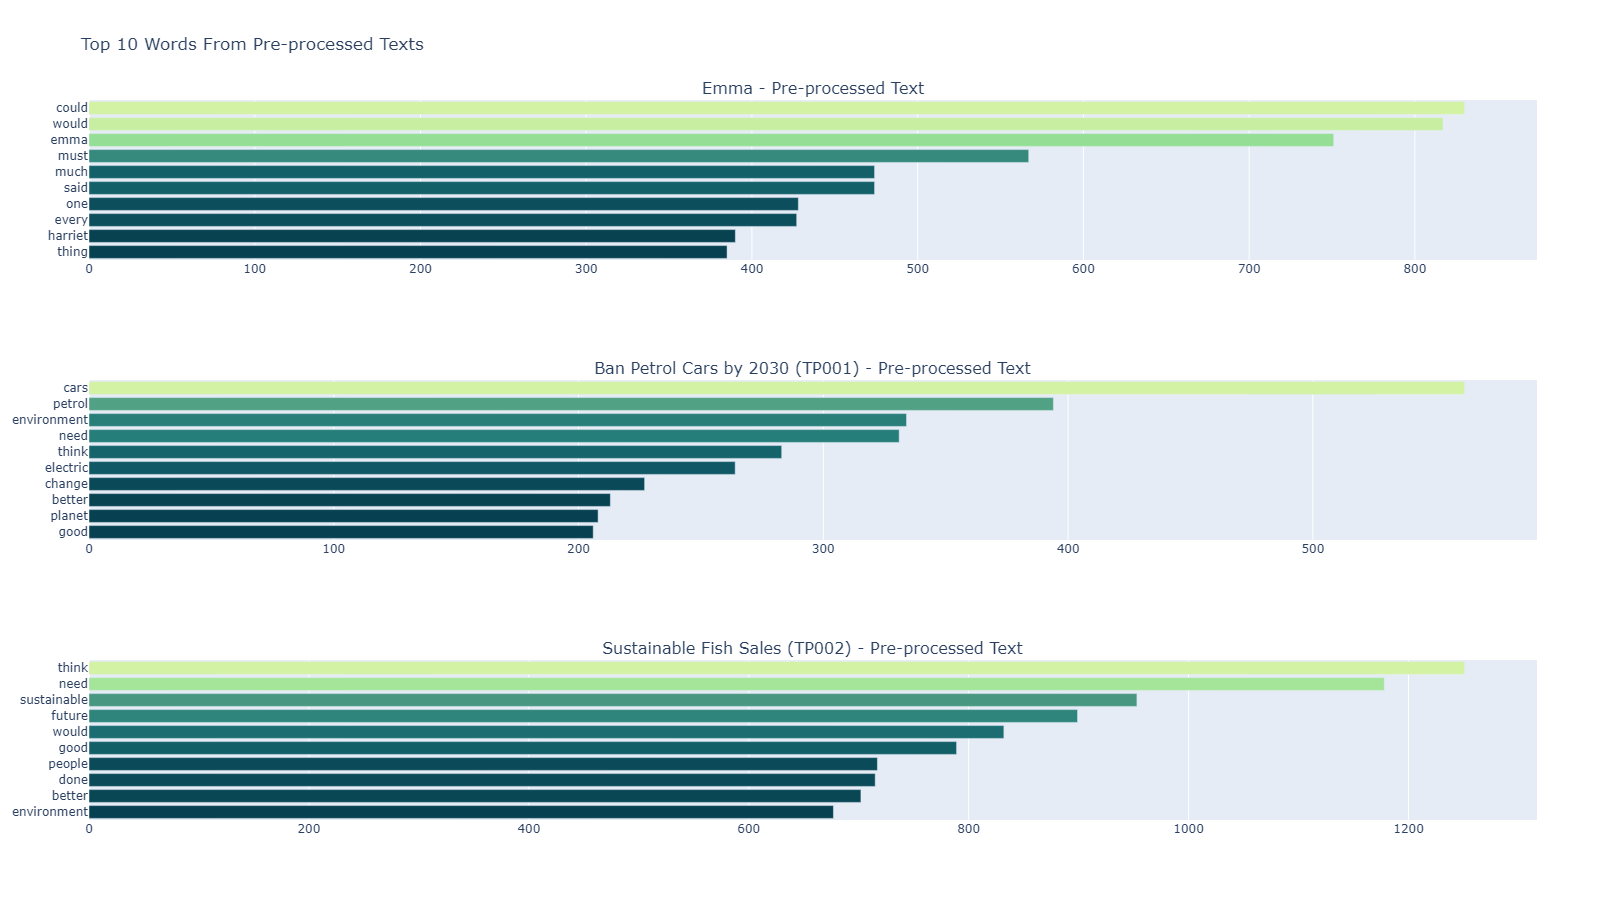

In the "Emma" pre-processed text, honorifics such as 'mr' and 'mrs' top the list, indicating a focus on social status and interaction, which is typical for Jane Austen’s work. The verbs 'could', 'would', and 'must' also feature prominently, reflecting the novel's narrative style and the contemplative nature of the characters.

For "TP001," the term 'cars' is the most frequent, emphasizing the text's subject of automobile use and its environmental implications. The presence of words like 'petrol', 'environment', 'electric', and 'planet' suggests a strong environmental theme, with a focus on the transition from petrol to electric vehicles and the overall impact on the planet.

In "TP002," 'think' and 'need' are the most frequent words, which indicates the reflective discussion on sustainability. The word 'sustainable' itself appears prominently, along with 'future' and 'environment', showing the text's emphasis on long-term environmental sustainability in relation to fish sales.

The graph indicates that this simple pre-processing has effectively highlighted key thematic terms in each text. The presence of specific words like 'electric' in TP001 and 'sustainable' in TP002 points to the central concerns of the texts, while the frequent use of modals in "Emma" suggests narrative modality. This visualization helps to quickly identify the primary focus of each text following the preprocessing stage.

In [36]:
# @title Preprocessing {display-mode: "form"}
# @markdown These sliders were designed to help select the ideal frequency range for text removal during preprocessing. The "upper bound" (ub) setting is used for excluding overly common words that aren't stopwords from the analysis. When a word's frequency exceeds this upper limit, it is removed from the text.
# @markdown
# @markdown The "lower bound" (lb) setting targets infrequently used words. Words that appear less often than this lower threshold are considered too rare to be relevant and are thus excluded. These might include typographical errors, extremely niche terms, or words that are highly specific to the text's context.

# Upper and lower bounds for word removal
emma_ub = 4901 # @param {type:"slider", min:1, max:5000, step:5}
emma_lb = 96 # @param {type:"slider", min:1, max:5000, step:5}
tp001_ub = 800 # @param {type:"slider", min:1, max:5000, step:5}
tp001_lb = 11 # @param {type:"slider", min:1, max:5000, step:5}
tp002_ub = 2000 # @param {type:"slider", min:1, max:5000, step:5}
tp002_lb = 300 # @param {type:"slider", min:1, max:5000, step:5}

# Preprocess the texts
tf_emma = preprocess_tf(emma_text, stop_words, emma_lb, emma_ub)
tf_tp001 = preprocess_tf(tp001_text, stop_words, tp001_lb, tp001_ub)
tf_tp002 = preprocess_tf(tp002_text, stop_words, tp002_lb, tp002_ub)

# Get text metrics
tf_emma_metrics = text_metrics(tf_emma)
tf_tp001_metrics = text_metrics(tf_tp001)
tf_tp002_metrics = text_metrics(tf_tp002)

# Prepare titles and metrics for printing
tf_titles = ["Emma - Preprocessed Text", "Ban Petrol Cars by 2030 (TP001) - Preprocessed Text", "Sustainable Fish Sales (TP002) - Preprocessed Text"]
tf_metrics_list = [tf_emma_metrics, tf_tp001_metrics, tf_tp002_metrics]
format_metrics(tf_titles, tf_metrics_list)

--------- Text Metrics for Emma - Preprocessed Text ---------
Total Words: 24950
Overall Lexical Diversity: 0.44%
Top Ten Most Frequent Words: 'mr' (1124), 'could' (830), 'would' (817), 'emma' (751), 'mrs' (687), 'miss' (587), 'must' (567), 'much' (474), 'said' (474), 'one' (428)
Highest Frequency Word: 'mr' (Frequency: 1124)

--------- Text Metrics for Ban Petrol Cars by 2030 (TP001) - Preprocessed Text ---------
Total Words: 13353
Overall Lexical Diversity: 2.31%
Top Ten Most Frequent Words: 'cars' (562), 'petrol' (394), 'environment' (334), 'need' (331), 'think' (283), 'electric' (264), 'change' (227), 'better' (213), 'planet' (208), 'good' (206)
Highest Frequency Word: 'cars' (Frequency: 562)

--------- Text Metrics for Sustainable Fish Sales (TP002) - Preprocessed Text ---------
Total Words: 17769
Overall Lexical Diversity: 0.19%
Top Ten Most Frequent Words: 'think' (1251), 'need' (1178), 'sustainable' (953), 'future' (899), 'would' (832), 'good' (789), 'people' (717), 'done' (715

In [11]:
# Plot the top 10 words from each text
plot_word_frequency(tf_metrics_list, 10, tf_titles, "Top 10 Words From Preprocessed Texts")

###**Analysis of Results of Preprocessing Sentences Without Term Frequency Filtering**

Analyzing the text metrics for "Emma," "Ban Petrol Cars by 2030" (TP001), and "Sustainable Fish Sales" (TP002) reveals the differences between sentence-level preprocessing and the previous method to preprocessing.

#### **Standard Preprocessing**
In the standard preprocessing method, where the text is treated as a continuous block of words, the focus is primarily on individual words without regard to their placement in sentences. This results in a lower overall word count and reduced lexical diversity. For instance, in Emma, the total word count post-standard preprocessing is 24,950, with an overall lexical diversity of just 0.44%. Similarly, in TP001 and TP002, the focus on individual words brings forward key thematic terms like 'cars', 'petrol', and 'environment' for TP001, and 'fish', 'think', and 'need' for TP002.

#### **Sentence-Level Preprocessing**
When preprocessing at the sentence level, there's a noticeable increase in both word count and lexical diversity. For Emma, the word count jumps to 81,036, and the lexical diversity increases significantly to 10.92%. This increase is attributed to the preservation of sentence structure, which maintains the narrative flow and context. The high average lexical diversity per sentence (e.g., 98.58% for "Emma") indicates that most sentences are unique in their composition, highlighting the richness and variability in language usage within the text.

#### **Pros and Cons of Sentence-Level Preprocessing**
**Pros**:
- **Sentence Structure Preservation**: Sentence-level preprocessing maintains the integrity of the sentence structure, which is important for understanding the context and narrative flow of a text.
- **Richer Lexical Diversity**: By considering sentences as units, this approach captures a more diverse range of vocabulary, reflecting the use of language in the text.

**Cons**:
- **Potential for Noise**: In retaining more words (including less significant ones), there's a risk of introducing 'noise' or less relevant information into the analysis.
- **Punctuation as Words**: The inclusion of punctuation in word counts can sometimes skew the understanding of the most frequently used terms.

####**Top Ten Words**
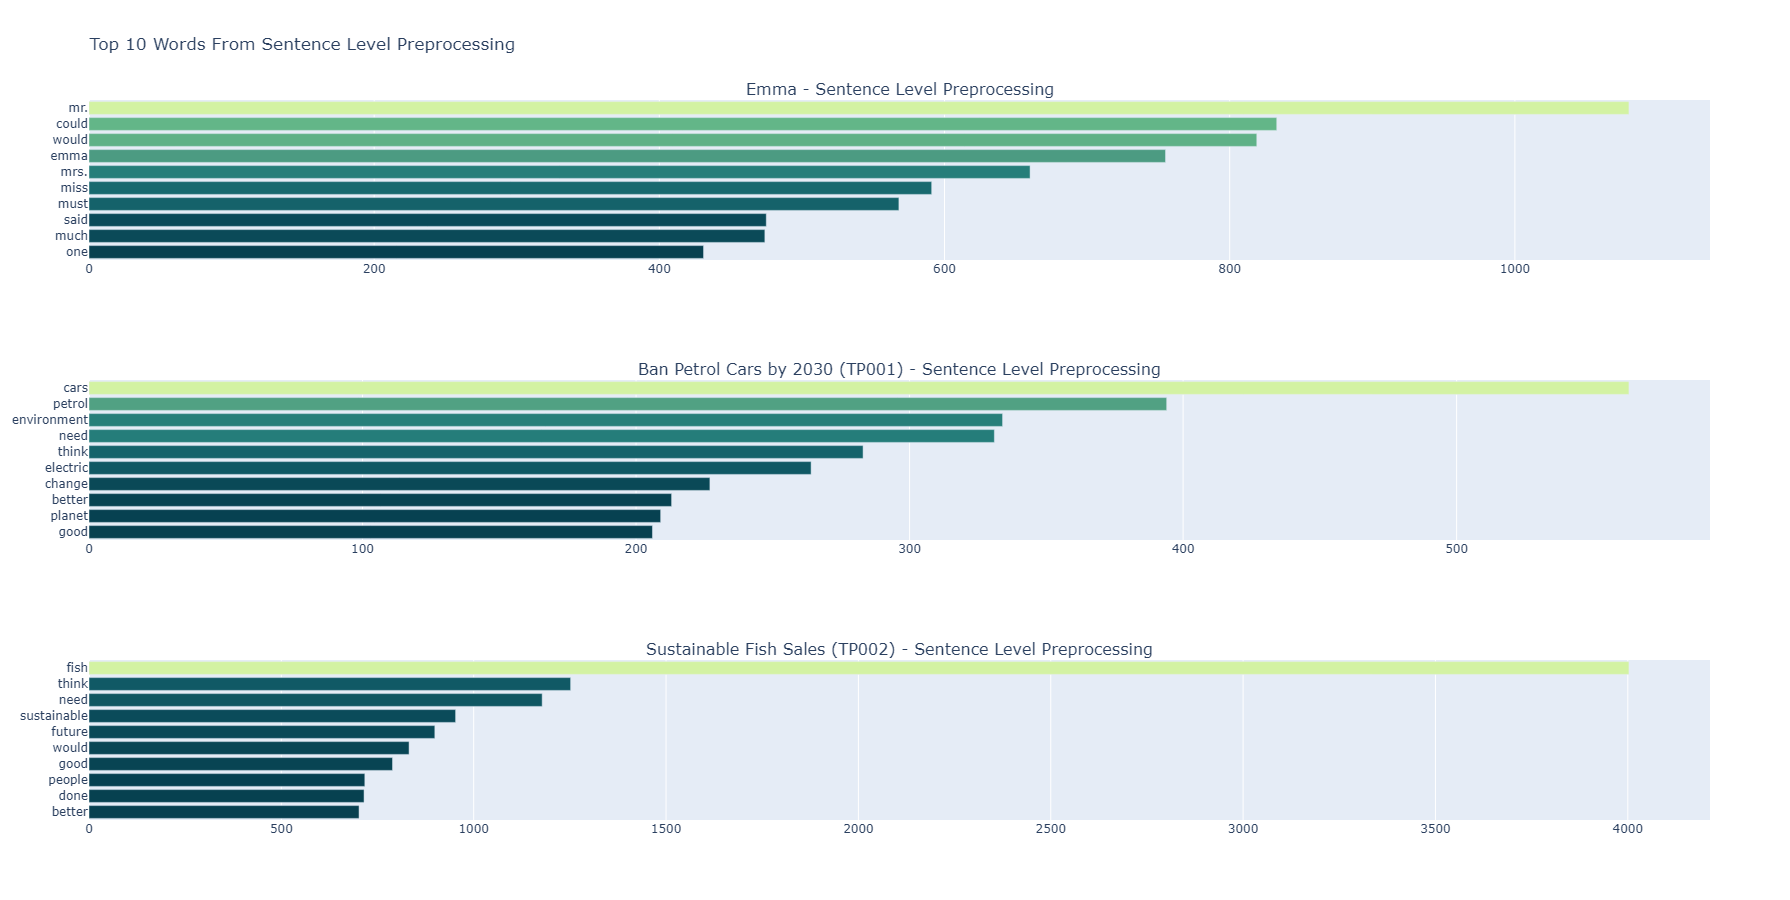

The graph illustrates the effects of preprocessing that retains sentence structure, which can lead to different insights compared to processing that focuses purely on word frequency. This approach is particularly useful for texts where the flow and style contribute significantly to meaning, such as in literature or persuasive writing.

In [47]:
# @title Preprocessing {display-mode: "form"}
def preprocess_sentences(text, stop_words):
    sentences = sent_tokenize(text)
    processed_sentences = []

    for sentence in sentences:
        # Must keep delimiters in cleaning, I exclude them from metrics
        processed_sentence = clean_text(sentence, stop_words, remove_punctuation=True, to_lowercase=True, keep_delimiters=True)
        processed_sentences.append(processed_sentence)

    # Combine the processed sentences into a single text
    return ' '.join(processed_sentences)

# Preprocess each text at the sentence level
tf_emma_sen = preprocess_sentences(emma_text, stop_words)
tf_tp001_sen = preprocess_sentences(tp001_text, stop_words)
tf_tp002_sen = preprocess_sentences(tp002_text, stop_words)

# Calculate text metrics for each preprocessed text
tf_emma_sen_metrics = text_metrics(tf_emma_sen, exclude_delimiters=True)
tf_tp001_sen_metrics = text_metrics(tf_tp001_sen, exclude_delimiters=True)
tf_tp002_sen_metrics = text_metrics(tf_tp002_sen, exclude_delimiters=True)

# Prepare titles and metrics for display
tf_titles_sen = ["Emma - Sentence Level Preprocessing", "Ban Petrol Cars by 2030 (TP001) - Sentence Level Preprocessing", "Sustainable Fish Sales (TP002) - Sentence Level Preprocessing"]
tf_metrics_sen_list = [tf_emma_sen_metrics, tf_tp001_sen_metrics, tf_tp002_sen_metrics]

# Format and print the metrics
format_metrics(tf_titles_sen, tf_metrics_sen_list, is_preprocessed=False)

--------- Text Metrics for Emma - Sentence Level Preprocessing ---------
Total Words: 81036
Total Sentences: 8272
Average Lexical Diversity of Sentences: 98.58%
Overall Lexical Diversity: 10.92%
Top Ten Most Frequent Words: 'mr.' (1080), 'could' (833), 'would' (819), 'emma' (755), 'mrs.' (660), 'miss' (591), 'must' (568), 'said' (475), 'much' (474), 'one' (431)
Highest Frequency Word: 'mr.' (Frequency: 1080)

--------- Text Metrics for Ban Petrol Cars by 2030 (TP001) - Sentence Level Preprocessing ---------
Total Words: 20539
Total Sentences: 413
Average Lexical Diversity of Sentences: 94.19%
Overall Lexical Diversity: 17.67%
Top Ten Most Frequent Words: 'cars' (563), 'petrol' (394), 'environment' (334), 'need' (331), 'think' (283), 'electric' (264), 'change' (227), 'better' (213), 'planet' (209), 'good' (206)
Highest Frequency Word: 'cars' (Frequency: 563)

--------- Text Metrics for Sustainable Fish Sales (TP002) - Sentence Level Preprocessing ---------
Total Words: 72649
Total Sente

In [48]:
# Plot the top 10 words from each text
plot_word_frequency(tf_metrics_sen_list, 10, tf_titles_sen, "Top 10 Words From Sentence Level Preprocessing")

# **Further Experimentation and Analysis**
This section inclues:
- Enhancing Text Analysis with TF-IDF Weight-Based Refinement
- Exploring Contextual Relevance in the Flitering Aspect of Text Preprocessing
- Computational Considerations in Context-Based Text Preprocessing
- Assessing the Impact of TF-IDF Filtering on Text Preprocessing
- Insights from the Application of Context-Based Preprocessing Techniques

## **Text Preprocessing Using Term Frequency - Inverse Document Frequency (TF-IDF) Filtering**
This function is based on the principle of refining a text corpus to enhance the salience of its content for computational analysis. It operates on the premise that the most informative words in a document are neither too common across the entire corpus (as they do not provide unique information) nor too rare (as they may not contribute significantly to the overall understanding of the content). The process of TF-IDF itself transforms textual information into a numerical format suitable for machine learning models, attributing to each word a weight that reflects its importance.

The TF-IDF vectorization at the core of this function scores each word based on its term frequency (TF), the number of times a word appears in a document, tempered by its inverse document frequency (IDF), which diminishes the weight of terms that occur very frequently across the corpus. This scoring mechanism inherently balances the need to recognize important terms within individual documents against the need to filter out terms that are too commonplace to be distinctive or too unusual to be characteristic. By summing the TF-IDF scores for each term across all documents, the function assesses the overall importance of each term within the entire corpus.

The subsequent filtering process is where I have slightly customized the TF-IDF approach by imposing percentile thresholds, essentially slicing away the upper and lower extremes of the term weight spectrum.

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def preprocess_tf_idf(texts, stop_words, idf_percentile_lower=10, idf_percentile_upper=90):
    # Tokenize and clean each document
    clean_docs = [clean_text(text, stop_words) for text in texts]

    # Create a TF-IDF Vectorizer
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(clean_docs)

    # Get feature names and TF-IDF score
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

    # Calculate percentile thresholds
    lower_threshold = np.percentile(tfidf_scores, idf_percentile_lower)
    upper_threshold = np.percentile(tfidf_scores, idf_percentile_upper)

    # Filter words based on TF-IDF scores
    filtered_words = [feature_names[i] for i in range(len(feature_names))
                      if lower_threshold <= tfidf_scores[i] <= upper_threshold]

    # Reconstruct the documents using filtered words
    preprocessed_texts = []
    for doc in clean_docs:
        words = doc.split()
        preprocessed_texts.append(" ".join([word for word in words if word in filtered_words]))

    return preprocessed_texts

## **Text Preprocessing Using a Novel Approach to Context-based Filtering**

The strategy employed in this text preprocessing method centers on preserving the essence and relevance of the text while eliminating extraneous or irrelevant content. This approach attempts to align with the overarching objective of distilling text to its most significant elements, ensuring that the core themes and messages remain intact. By focusing on the crux of the text, it seeks to enhance the clarity and impact of the information conveyed.

#### **Emphasizing Contextual Relevance over Frequency**

A key component of this method is a shift away from traditional frequency-based analysis, which prioritizes words based on how often they appear, regardless of their contextual significance. Instead, this approach attempts to look deeper into the contextual relationships and meanings of terms within the text. By evaluating sentences for their semantic similarity to specific keywords or keyphrases, the method acknowledges the importance of context in understanding the relevance of words and phrases within a text. This technique is particularly adept at capturing the nuanced and semantic layers of language, which can be overlooked in simpler, frequency-centric approaches.

#### **Sentence-Level Semantic Filtering**

In this approach, I have attempted to achieve contextual relevance by first decomposing the text into individual sentences, followed by generating embeddings for each sentence. These embeddings are essentially rich, multi-dimensional representations capturing the semantic essence of each sentence. When these sentence embeddings are compared with predefined keyword embeddings through cosine similarity, the function effectively assesses the relevance of each sentence to the targeted topics or themes. This comparison is not a strict superficial matching of words but an evaluation of the sentence's thematic alignment with the keywords. Sentences that exhibit a high degree of similarity to the keywords, as determined by the predefined threshold, are retained. This threshold acts as a crucial gatekeeper, ensuring that only content closely aligned with the primary themes is included in the processed text.

However, there are a few drawbacks to this approach. Firstly, computational complexity: The process of generating and comparing embeddings for each sentence can be computationally intensive, especially for longer texts such as Emma. This often leads to longer processing times which require more compute resources.

Secondly, dependence on the quality of embeddings: The effectiveness of this method heavily relies on the quality of the sentence and keyword embeddings. If these embeddings do not accurately capture the semantic nuances of the text, the similarity assessment can be misleading.

Additionally, setting an appropriate threshold for similarity is challenging. If the threshold is set too high, important sentences might be excluded; too low, and the filtered text could still contain irrelevant information.

In [29]:
import torch
from transformers import BertTokenizer, BertModel

# Setting up the device for GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the tokenizer and model
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name).to(device)

# Checking if CUDA is available and getting the GPU device name
cuda_available = torch.cuda.is_available()
gpu_name = torch.cuda.get_device_name(0) if cuda_available else "No CUDA Device Available"

cuda_available, gpu_name

(True, 'Tesla T4')

In [31]:
# Function to create BERT embeddings
def create_embeddings(text, model=model, tokenizer=tokenizer, device='cuda'):
    # Tokenize the input text and convert it to tensor format suitable for BERT
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512, add_special_tokens=True)
    # Move the inputs to the specified device (GPU or CPU)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Put the model in evaluation mode to deactivate dropout layers
    model.eval()

    # Compute the model output without calculating gradients (for efficiency)
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the hidden states from the last layer of the BERT model
    hidden_states = outputs.last_hidden_state
    # Compute the mean of the hidden states to get a single vector (embedding) for the entire text
    text_embedding = hidden_states.mean(dim=1).squeeze(0)

    return text_embedding

In [17]:
from nltk.tokenize import sent_tokenize
import torch.nn.functional as F

# Main function to preprocess text based on similarity to keywords
def preprocess(text, keyword_embeddings, stop_words, threshold=0.5):
    # Tokenize the text into individual sentences
    sentences = sent_tokenize(text)
    filtered_sentences = []

    for sentence in sentences:
        # Generate embeddings for each sentence
        sentence_embedding = create_embeddings(sentence)

        # Calculate cosine similarity between sentence and each keyword embedding
        similarities = [F.cosine_similarity(
                            sentence_embedding.unsqueeze(0),
                            keyword_emb.unsqueeze(0), dim=1)
                            for keyword_emb in keyword_embeddings]

        # Determine if any similarity score exceeds the defined threshold
        similarity_above_threshold = any(similarity > threshold for similarity in similarities)

        # Include the sentence in the final text if it is similar enough to any of the keywords
        if similarity_above_threshold:
            filtered_sentences.append(sentence)

    # Join the selected sentences back into a single processed text
    processed_text = ' '.join(filtered_sentences)

    # Clean the processed text by removing stop words
    return clean_text(processed_text, stop_words)

### **Keyword Extraction**
This function utilizes the [KeyBERT](https://github.com/MaartenGr/KeyBERT) library to identify key phrases within a text. For the approach to be effective, it's crucial to select phrases that are not only significant in the context of the text but also offer a diverse range of themes or topics. KeyBERT harnesses the power of [BERT](https://arxiv.org/pdf/1810.04805.pdf) (Bidirectional Encoder Representations from Transformers) embeddings. These embeddings offer a deep semantic understanding of language, which is important in extracting keywords that are not just frequent but meaningfully associated with the text's themes.

In analyzing Emma, a text characterized by its complexity and depth, I recognize a need for a keyword extraction strategy that would capture a broad spectrum of themes. To address this, I introduced an option in the function to diversify the extracted keywords. This diversification is important for a text like "Emma," which encompasses a rich variety of themes and narratives.

When the need for diversity in keywords arise, the function employs the Maximal Marginal Relevance ([MMR](https://maartengr.github.io/KeyBERT/api/mmr.html)) algorithm. MMR is adept at balancing the relevance of each keyword to the text against its uniqueness compared to other selected keywords. This ensures that the chosen keywords are not only relevant to the text's subject matter but also diverse, covering a wide range of topics and themes. The iterative nature of MMR's selection process is especially beneficial for a text like Emma, as it aligns with the goal of capturing the multitude of facets and nuances within its narrative. By using MMR, the function aims to provide a comprehensive set of keywords that collectively represent the diverse elements of the text.

The function also utilizes the [MaxSum](https://maartengr.github.io/KeyBERT/api/maxsum.html) algorithm in situations where a high degree of diversification in keyword selection is not essential and might actually impede the extraction of keywords that are most significant in the given context. This method is effective for texts with a specific, concentrated subject matter and a predominant theme, as seen in TP001 and TP002.

After the extraction of keywords, the function processes these terms through a tokenizer and encodes them into embeddings via BERT. These embeddings play an important role downstream where we look at the similarites between these keyphrase embeddings and sentence embeddings.

In [21]:
!pip install keybert

In [23]:
from keybert import KeyBERT
import torch

# Initialize the KeyBERT model
kw_model = KeyBERT()

def extract_keywords(text, num_keywords=5, diversify=False, diversity=0.5):
    # Set the range for n-grams and the list of stop words to be used
    keyphrase_ngram_range = (3, 3)
    stop_words = 'english'

    # Extract keywords using KeyBERT with options for diversification
    if diversify:
        # Use MMR for diversification to get varied keywords
        keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=keyphrase_ngram_range,
                                            stop_words=stop_words, use_mmr=True, diversity=diversity)
    else:
        # Use MaxSum to get the most relevant keywords
        keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=keyphrase_ngram_range,
                                            stop_words=stop_words, use_maxsum=True,
                                            nr_candidates=20, top_n=num_keywords)

    # Isolate just the keywords from the output tuples
    extracted_keywords = [keyword[0] for keyword in keywords]

    # Tokenize and encode the extracted keywords for embedding generation
    key_word_tokens = tokenizer(extracted_keywords, padding=True, return_tensors="pt").to(device)

    # Generate embeddings for the keywords without gradient calculation
    with torch.no_grad():
        key_word_outputs = model(**key_word_tokens)
    key_word_embeddings = key_word_outputs.last_hidden_state.mean(dim=1)

    # Return the embeddings and the extracted keywords
    return {
        'key_word_embeddings': key_word_embeddings,
        'keywords': extracted_keywords
    }

##**Analyzing Preprocessed Texts Using TF-IDF Based Filtering**
The text metrics for TP001, TP002, and "Emma" after TF-IDF preprocessing reveal interesting shifts in vocabulary and focus, as evidenced by the lexical diversity and the most frequent words.

**Emma**

Emma displays a total word count of 18,428 with an overall lexical diversity of 43.08%. This is the lowest diversity among the three texts, which could be a reflection of the narrative style of the novel where certain themes or motifs are revisited throughout. The top ten frequent words are quite distinctive; terms like 'miles', 'anywhere', and 'laughing' are prominent, each with a frequency of 16. This selection of words may point to elements of travel, spatial settings, character emotions, and social interactions, all of which are crucial components in Austen's writing. Words such as 'comprehend', 'assistance', and 'compliments' further suggest a narrative rich in social exchange and personal development. The presence of these terms indicates that, even within the refined dataset post-TF-IDF preprocessing, the novel's focus on character dynamics and societal norms remains clear.

**TP001**

TP001, after TF-IDF preprocessing, has a total word count of 3,445 and a notably high overall lexical diversity of 72.31%. This high diversity indicates this filtering method retained a wide variety of language usage and removed a significantly large portion of the text, which is interesting for a text with a relatively small total word count. The top ten words include terms like 'warfare', 'polite', and 'subsidies', each occurring with a frequency of 5 or 6. The presence of 'warfare' as the highest frequency word hints at the texts discussions of conflict or competition, in the context of automotive industry challenges and environmental policy debates. The inclusion of 'polite' and 'subsidies' could also indicate some discussion around social conduct or economic incentives related to the topic. The relatively even distribution of the frequencies among the top words points to a balanced treatment of these themes within the text.

**TP002**

The TF-IDF preprocessed metrics for TP002 show a total word count of 12,878 and a lexical diversity of 51.09%. The lower diversity compared to TP001 might be due to a more focused thematic content or a higher repetition of key terms. The frequent words like 'top', 'choose', 'thriving', and 'protection', with 'top' appearing 19 times, suggest a narrative that emphasizes choice, success, and safety within the context of sustainable fisheries. The term 'ecology' underscores the environmental aspect, while 'rights', 'forever', and 'sale' hint at the legal and commercial dimensions. The prevalence of these words indicates a comprehensive exploration of sustainability in fisheries, covering ecological, legal, and economic angles.

In the context of TF-IDF preprocessing, as applied to these text's we observe that the frequencies of the top words are substantially lower than those found through basic term frequency or context-based filtering methods. This is a direct consequence of how TF-IDF operates, with its unique balancing act between term frequency and inverse document frequency. Because the core principle of TF-IDF lies in valuing words not by how often they appear in a single document but by how they are distributed across the entire corpus. Common words like 'the' and 'and', which typically dominate term frequency counts, are deprioritized in TF-IDF because they offer little distinctive information about a document's content. Instead, TF-IDF raises the profile of words that, while they may appear less frequently, are more telling of a document’s unique subject matter. This results in a lower frequency count for the most weighted words, as TF-IDF is calibrated to bring forward terms that are comparatively rare in the corpus yet significant within individual texts.

In all, these metrics demonstrate the distinctive impacts of TF-IDF preprocessing on different types of text. For TP001 and TP002, the preprocessing seems to have distilled the texts down to their thematic essences, while for "Emma", the process has highlighted key narrative and stylistic elements. The lexical diversity in each case reflects the text's complexity and the range of vocabulary employed to convey its themes.

In [24]:
# Preprocess the texts using TF-IDF
texts = [tp001_text, tp002_text, emma_text]
preprocessed_texts = preprocess_tf_idf(texts, stop_words)
tf_idf_tp001 = preprocessed_texts[0]
tf_idf_tp002 = preprocessed_texts[1]
tf_idf_emma = preprocessed_texts[2]

# Calculate metrics for each preprocessed text
tf_idf_tp001_metrics = text_metrics(tf_idf_tp001)
tf_idf_tp002_metrics = text_metrics(tf_idf_tp002)
tf_idf_emma_metrics = text_metrics(tf_idf_emma)

# Display formatted metrics
titles_tf_idf = ["TP001 - TF-IDF Preprocessed Text", "TP002 - TF-IDF Preprocessed Text", "Emma - TF-IDF Preprocessed Text"]
metrics_tf_idf = [tf_idf_tp001_metrics, tf_idf_tp002_metrics, tf_idf_emma_metrics]
format_metrics(titles_tf_idf, metrics_tf_idf)

--------- Text Metrics for TP001 - TF-IDF Preprocessed Text ---------
Total Words: 3445
Overall Lexical Diversity: 72.31%
Top Ten Most Frequent Words: 'warfare' (6), 'polite' (6), 'individual' (5), 'handle' (5), 'subsidies' (5), 'sets' (5), 'significant' (5), 'total' (5), 'breath' (5), 'fight' (5)
Highest Frequency Word: 'warfare' (Frequency: 6)

--------- Text Metrics for TP002 - TF-IDF Preprocessed Text ---------
Total Words: 12878
Overall Lexical Diversity: 51.09%
Top Ten Most Frequent Words: 'top' (19), 'choose' (19), 'thriving' (19), 'protection' (18), 'board' (18), 'ecology' (18), 'rights' (17), 'forever' (17), 'fishery' (17), 'sale' (16)
Highest Frequency Word: 'top' (Frequency: 19)

--------- Text Metrics for Emma - TF-IDF Preprocessed Text ---------
Total Words: 18428
Overall Lexical Diversity: 43.08%
Top Ten Most Frequent Words: 'miles' (16), 'anywhere' (16), 'laughing' (16), 'reached' (16), 'comprehend' (15), 'opening' (15), 'assistance' (15), 'compliments' (15), 'refuse' (1

##**Analyzing Texts Preprocessed With Context-Based Filtering**
> *This section is computationally and resource intensive, it can also take a while to run, typically under five minutes on a Tesla T4 in the colab runtime environment. It can be skipped.*

The text metrics following context-based preprocessing for TP001, TP002, and "Emma" provide a fascinating glimpse into how this method filters and refines the language used in each text, centering on the most thematically relevant words.

#### **Emma**
For "Emma," context-based preprocessing yields a total word count of 44,743 and a lexical diversity of 16.72%. Character names like 'mr', 'emma', 'mrs', 'miss', and 'harriet' feature prominently, highlighting the novel's focus on social relations and character development. Verbs such as 'could', 'would', and 'must', with their relatively high frequencies, reflect the conditional and speculative aspects of the narrative, possibly indicating the characters’ introspection and the hypothetical scenarios often posed by Austen. The lexical diversity is greater than TP002 but less than TP001, which may reflect a balance between narrative-driven prose and the diverse social settings and interactions that characterize the novel.

#### **TP001**

TP001 emerges from context-based preprocessing with a total word count of 19,975 and an overall lexical diversity of 18.04%. The lexical diversity here is modest, which is again indicative of a focused topic within the text. The prominence of 'cars' with a frequency of 560 signals the text’s central theme. Other high-frequency words like 'petrol', 'environment', 'electric', and 'change' reinforce the environmental focus of the text, related to the automotive industry and its impact on the planet. Terms such as 'need', 'think', 'better', and 'good' suggest an evaluative and prescriptive discourse, as the text may be advocating for change and considering improvements within the context of the subject matter.

#### **TP002**
The preprocessing of TP002 results in a total word count of 63,204 and a lexical diversity of 11.77%, the lowest among the three texts. This could imply a high recurrence of certain terms due to the text’s narrow focus or the repeated discussion of specific concepts. Words like 'sustainable', 'future', 'good', 'better', 'people', and 'environment' accompany 'fish', painting a comprehensive picture of the sustainability narrative and its implications for the future. The metrics suggest a detailed exploration of sustainability in the fishing industry, considering not only environmental aspects but also social and ethical dimensions.

Across all three texts, context-based preprocessing has distilled the language to foreground the words most relevant to each text's central themes. In TP001 and TP002, this method accentuates the environmental and sustainability discussions, while in Emma, it brings out the social and personal dynamics that are quintessential to Jane Austen's storytelling. These metrics not only provide a quantitative overview of the text's content but also qualitatively reflect the depth and focus of the discourse within each text.

In [25]:
# Extracting keywords for preprocessing
num_tp001_keywords = 7
tp001_keywords = extract_keywords(tp001_text, num_tp001_keywords)
print(tp001_keywords['keywords'])

num_tp002_keywords = 8
tp002_keywords = extract_keywords(tp002_text, num_tp002_keywords)
print(tp002_keywords['keywords'])

['sustainable alternative need', 'impact banning petrol', 'think banning cars', 'reduce emissions need', 'climate change ban', 'sustainable change better', 'banned 2030 environment']
['investing sustainable fishing', 'sustainable fishing economy', 'fishing allowed sustainability', 'paying sustainable fishing', 'sustainable continue fishing', 'sustainable fishing priority', 'sell sustainable fishing', 'idea sustainable fishing']


In [26]:
num_emma_keywords = 25
emma_keywords = extract_keywords(emma_text, num_emma_keywords, diversify=True, diversity=0.7)
print(emma_keywords['keywords'])

emma_keyword_embeddings = emma_keywords['key_word_embeddings']
tp001_keyword_embeddings = tp001_keywords['key_word_embeddings']
tp002_keyword_embeddings = tp002_keywords['key_word_embeddings']

['unsuspected emma circumstances', 'father inherited constitution', 'comfortable command command', 'income comparison enscombe', 'brewing spruce beer']


In [32]:
# Preprocess TP001 text
preprocessed_tp001 = preprocess(tp001_text, tp001_keyword_embeddings, stop_words)
preprocessed_tp001_metrics = text_metrics(preprocessed_tp001)
format_metrics(["TP001 - Context based Preprocessing"], [preprocessed_tp001_metrics])

# Preprocess TP002 text
preprocessed_tp002 = preprocess(tp002_text, tp002_keyword_embeddings, stop_words)
preprocessed_tp002_metrics = text_metrics(preprocessed_tp002)
format_metrics(["TP002 - Context based Preprocessing"], [preprocessed_tp002_metrics])

# Preprocess Emma text
preprocessed_emma = preprocess(emma_text, emma_keyword_embeddings, stop_words)
preprocessed_emma_metrics = text_metrics(preprocessed_emma)
format_metrics(["Emma - Context based Preprocessing"], [preprocessed_emma_metrics])

--------- Text Metrics for TP001 - Context based Preprocessing ---------
Total Words: 19975
Overall Lexical Diversity: 18.04%
Top Ten Most Frequent Words: 'cars' (560), 'petrol' (392), 'environment' (334), 'need' (330), 'think' (283), 'electric' (263), 'change' (227), 'better' (212), 'planet' (208), 'good' (206)
Highest Frequency Word: 'cars' (Frequency: 560)

--------- Text Metrics for TP002 - Context based Preprocessing ---------
Total Words: 63204
Overall Lexical Diversity: 11.77%
Top Ten Most Frequent Words: 'fish' (3605), 'think' (1127), 'need' (1035), 'sustainable' (885), 'future' (823), 'would' (765), 'good' (719), 'better' (640), 'people' (633), 'environment' (628)
Highest Frequency Word: 'fish' (Frequency: 3605)

--------- Text Metrics for Emma - Context based Preprocessing ---------
Total Words: 44743
Overall Lexical Diversity: 16.72%
Top Ten Most Frequent Words: 'mr' (679), 'could' (590), 'would' (563), 'emma' (554), 'mrs' (416), 'miss' (373), 'must' (331), 'every' (297), 'o

## **Top Ten Words Before and After Both Preprocessing Methods**

The graphs provide a comparative analysis of the top ten words from the three different texts: before any preprocessing, after context-based preprocessing, and after TF-IDF preprocessing.

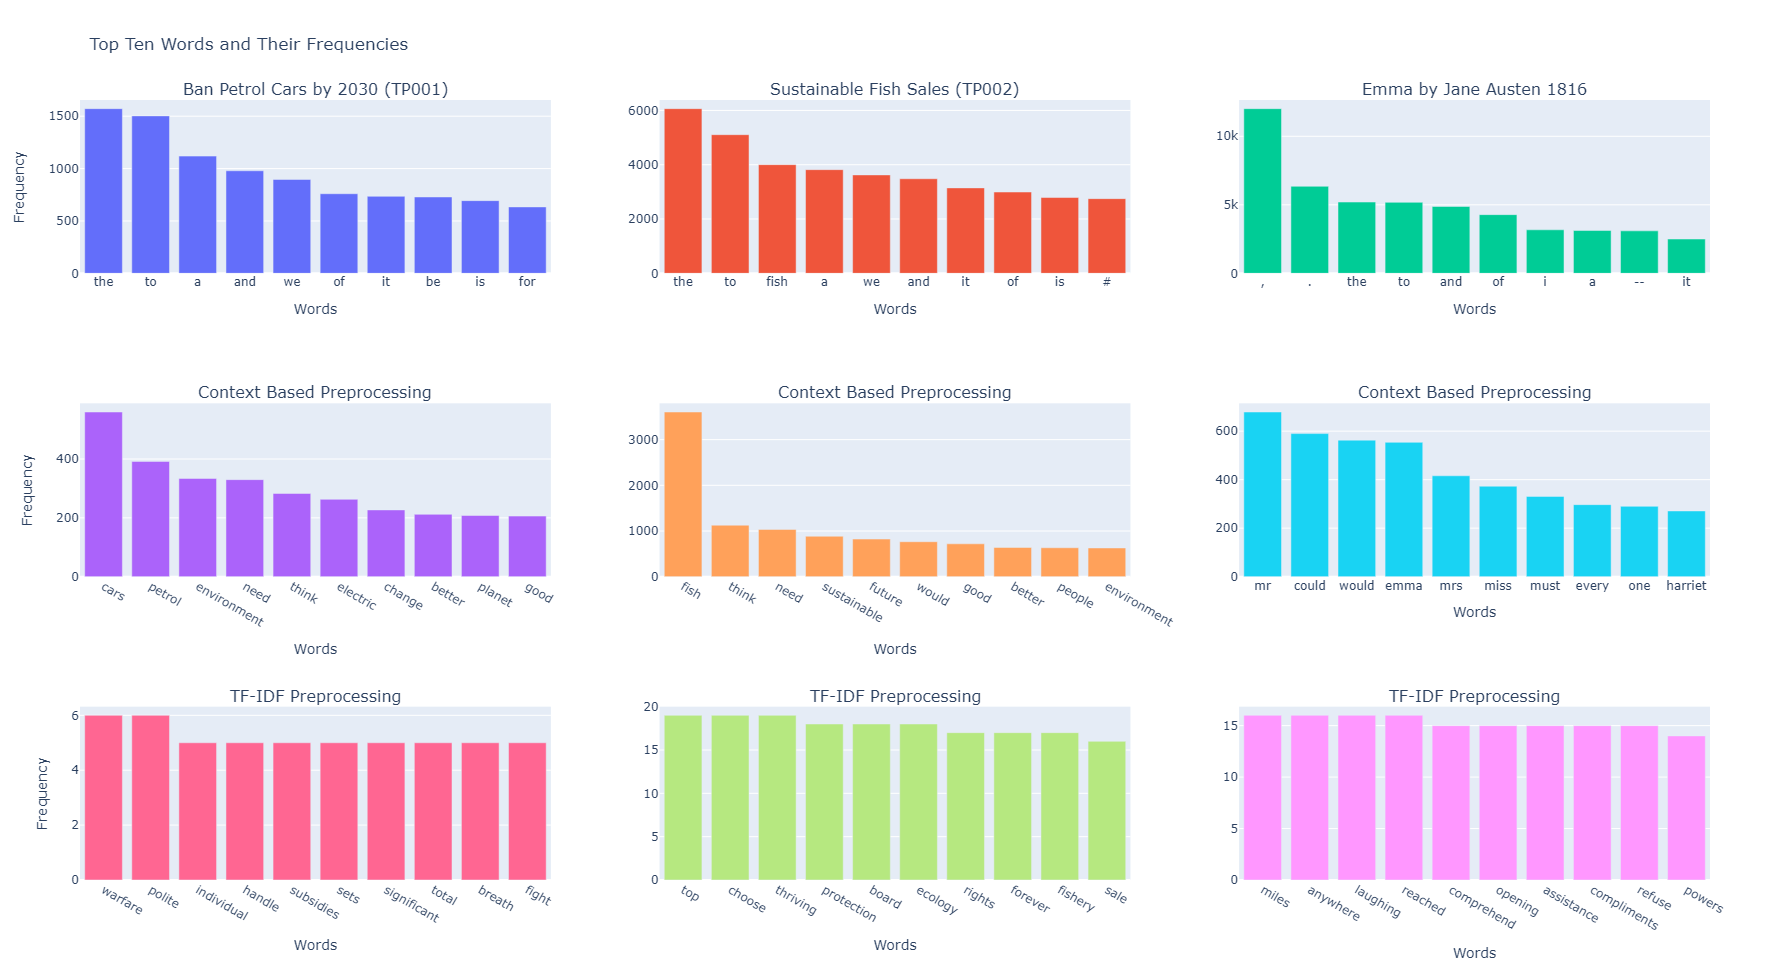

Initially, the raw frequency graphs reveal that stopwords such as "the", "to", and "and" are prevalent across all texts. These words, while frequent, usually offer minimal unique contextual information.

Post context-based preprocessing, there's a noticeable shift. The words that emerge as most frequent are indicative of the texts' topics. For instance, "cars", "electric", and "environment" for TP001, and "fish", "sustainable", and "future" for TP002. This indicates an effective removal of less informative words, highlighting those more relevant to the texts' specific content.

In "Emma", words like "would" and "could" persist post-processing, which may reflect their narrative importance in Jane Austen's writing style or the thematic content of the novel.

TF-IDF preprocessing yields words with lower raw frequencies, yet they are contextually weighted to signify their importance within their texts. Terms like "tax", "output", and "combustion" for TP001, and "feed", "treat", "thriving" for TP002, emerge, denoting not just frequency but distinctiveness within the corpus. This suggests that TF-IDF is successful in identifying terms that are not only relevant but also uniquely descriptive of the texts.

For "Emma", terms such as "laughing", "compliments", and "comprehend" are highlighted, pointing towards the unique thematic elements and motifs in the novel.

### Effects of Both Pre-processing Approaches on The Top Ten Words:
**Context-Based**
- Filters out common words, leaving behind those that align closely with the text's subject, offering a snapshot of the primary themes.
- May still retain frequently occurring words that are not categorized as stopwords but are not unique to the text's context.

This method has shown a consistent reliance on the keywords generated. It has performed notably well on texts like The Current, likely due to their focused content and smaller size, which perhaps allows KeyBert to generate more accurate keyphrases. The texts' dense and concentrated subject matter related to fish sales and the ban on petrol cars appears to contribute to the model's effective generalization, in contrast to more variable narrative contexts.

**TF-IDF**
- Assesses words based on uniqueness across texts, highlighting those that define a text's distinctive themes.
- While these words may not appear frequently, they carry significant weight in conveying the text's essence.
- Can uncover key topics and themes that frequency counts alone may miss.

### Trends and Observations:
- Following context-based preprocessing, the remaining words more accurately reflect the unique narrative style of the texts, showcasing a successful filtering of generic terms.
- The TF-IDF frequency range is notably lower, indicating that the highlighted words, although pivotal, are less common in general use. This underscores TF-IDF's utility in pinpointing words that are vital within a particular document and potentially rare in broader usage.

In [33]:
#@title ##Graph Generation {display-mode: "form"}
# Extracting top ten words and their frequencies for plotting
tp001_top_ten_words, tp001_frequencies = zip(*tp001_metrics['top_ten_words'])
tp002_top_ten_words, tp002_frequencies = zip(*tp002_metrics['top_ten_words'])
emma_top_ten_words, emma_frequencies = zip(*emma_metrics['top_ten_words'])

preprocessed_tp001_top_ten, preprocessed_tp001_freq = zip(*preprocessed_tp001_metrics['top_ten_words'])
preprocessed_tp002_top_ten, preprocessed_tp002_freq = zip(*preprocessed_tp002_metrics['top_ten_words'])
preprocessed_emma_top_ten, preprocessed_emma_freq = zip(*preprocessed_emma_metrics['top_ten_words'])

tf_idf_tp001_top_ten, tf_idf_tp001_freq = zip(*tf_idf_tp001_metrics['top_ten_words'])
tf_idf_tp002_top_ten, tf_idf_tp002_freq = zip(*tf_idf_tp002_metrics['top_ten_words'])
tf_idf_emma_top_ten, tf_idf_emma_freq = zip(*tf_idf_emma_metrics['top_ten_words'])

# Create a subplot figure with 3 rows and 3 columns (transposed)
fig = make_subplots(
    rows=3, cols=3,
    subplot_titles=(
        'Ban Petrol Cars by 2030 (TP001)',
        'Sustainable Fish Sales (TP002)',
        'Emma by Jane Austen 1816',
        'Context Based Preprocessing',
        'Context Based Preprocessing',
        'Context Based Preprocessing',
        'TF-IDF Preprocessing',
        'TF-IDF Preprocessing',
        'TF-IDF Preprocessing')
)

# Original TP001
fig.add_trace(
    go.Bar(x=tp001_top_ten_words, y=tp001_frequencies),
    row=1, col=1
)

# Original TP002
fig.add_trace(
    go.Bar(x=tp002_top_ten_words, y=tp002_frequencies),
    row=1, col=2
)

# Original Emma
fig.add_trace(
    go.Bar(x=emma_top_ten_words, y=emma_frequencies),
    row=1, col=3
)

# Preprocessed TP001
fig.add_trace(
    go.Bar(x=preprocessed_tp001_top_ten, y=preprocessed_tp001_freq),
    row=2, col=1
)

# Preprocessed TP002
fig.add_trace(
    go.Bar(x=preprocessed_tp002_top_ten, y=preprocessed_tp002_freq),
    row=2, col=2
)

# Preprocessed Emma
fig.add_trace(
    go.Bar(x=preprocessed_emma_top_ten, y=preprocessed_emma_freq),
    row=2, col=3
)

# TF-IDF TP001
fig.add_trace(
    go.Bar(x=tf_idf_tp001_top_ten, y=tf_idf_tp001_freq),
    row=3, col=1
)

# TF-IDF TP002
fig.add_trace(
    go.Bar(x=tf_idf_tp002_top_ten, y=tf_idf_tp002_freq),
    row=3, col=2
)

# TF-IDF Emma
fig.add_trace(
    go.Bar(x=tf_idf_emma_top_ten, y=tf_idf_emma_freq),
    row=3, col=3
)

# Update layout
fig.update_layout(
    title_text='Top Ten Words and Their Frequencies',
    showlegend=False,
    height=970
)

# Customize axis labels
for row in range(1, 4):
    for col in range(1, 4):
        fig.update_xaxes(title_text='Words', row=row, col=col)

fig.update_yaxes(title_text='Frequency', row=1, col=1)
fig.update_yaxes(title_text='Frequency', row=2, col=1)
fig.update_yaxes(title_text='Frequency', row=3, col=1)

# Show the figure
fig.show()